In [2]:
import os
import pandas as pd
import numpy as np
import torch
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    T5ForConditionalGeneration,
    T5Tokenizer,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import regex
import string
import requests
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Descărcăm resursele NLTK necesare
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\djtsms\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\djtsms\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Calea către fișierul CSV
file_path = 'C:\\Users\\djtsms\\Desktop\\Master\\MODUL 2\\Semantica si pragmatica limbajului natural-S1\\Proiect Old Team\\english_news_dataset.csv'

In [5]:
# Verifică dacă fișierul există
if not os.path.exists(file_path):
    print(f"Fișierul nu a fost găsit: {file_path}")
    exit()

In [6]:
# Încărcă datele
df = pd.read_csv(file_path)


In [7]:
# Afișează primele 10 rânduri
print(df.head(10))


                                            Headline  \
0  Congress leader Baljinder Singh shot dead at h...   
1  17-year-old girl preparing for NEET dies by su...   
2  Hampers to welcome MPs in new Parliament tomor...   
3  Only 10% women lawmakers in RS, while only 14%...   
4  Ganesh temple decorated with notes, coins wort...   
5  Bee attack during funeral in K'taka leaves 1 d...   
6  Manipur govt forms inquiry commission to probe...   
7  Cabinet approves Bill giving 33% reservation t...   
8  Won't accept his remains: Wife of Army soldier...   
9  Heavy to very heavy rainfall warning issued fo...   

                                             Content News Categories  \
0  Congress leader Baljinder Singh was shot dead ...    ['national']   
1  Another NEET aspirant died by suicide in Rajas...    ['national']   
2  In order to mark the first-ever working day of...    ['national']   
3  Congress President Mallikarjun Kharge, while s...    ['national']   
4  The Sri Sathya Ganap

In [8]:
# Gruparea claselor rare
threshold = 5
class_counts = df['News Categories'].value_counts()
rare_classes = class_counts[class_counts < threshold].index
df['category_grouped'] = df['News Categories'].apply(lambda x: 'Other' if x in rare_classes else x)

In [9]:
# Preprocesarea textului - un exemplu simplu pentru a elimina stopwords, punctuație, etc.


def remove_punc(text):
    """Elimină semnele de punctuație din text."""
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_emojis(text):
    """Elimină emoji-urile din text."""
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return emoji_pattern.sub('', text)

def remove_url(text):
    """Elimină URL-urile din text."""
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

def remove_stopwords(text):
    """Elimină stopword-urile din text."""
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

def preprocess_text(text):
    """Pipeline pentru preprocesarea textului."""
    if not isinstance(text, str) or text.strip() == "":
        return ""
    text = text.lower()
    text = remove_url(text)
    text = remove_emojis(text)
    text = remove_punc(text)
    text = remove_stopwords(text)
    return text

In [10]:
# Preprocesăm datele
df["Content"] = df["Content"].fillna("").apply(preprocess_text)

In [11]:
# Pregătirea datelor
X = df["Content"]
y = df["category_grouped"]

# Encoding labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Define the fraction of the dataset you want to keep for training
fraction = 0.2  # Poti schimba la un alt procent, de exemplu 0.2 pentru 20% din date

# Selecție aleatorie stratificată a unui subset din date
X_train_subset, _, y_train_subset, _ = train_test_split(
    X, y_encoded, 
    train_size=fraction, 
    stratify=y_encoded, 
    random_state=42
)

# Împărțirea datelor pentru testare
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [12]:
# Afișează dimensiunile pentru seturile de date
print(f"Numărul de exemple pentru antrenament: {X_train.shape[0]}")
print(f"Numărul de exemple pentru testare: {X_test.shape[0]}")

Numărul de exemple pentru antrenament: 159764
Numărul de exemple pentru testare: 39942


In [60]:
# Creăm seturi Huggingface pe baza subsetului
train_dataset = Dataset.from_dict({"Content": X_train_subset.tolist(), "labels": y_train_subset.tolist()})
test_dataset = Dataset.from_dict({"Content": X_test.tolist(), "labels": y_test.tolist()})

In [61]:
# Definirea tokenizer-ului și modelului global
distilbert_model_name = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(distilbert_model_name)
distilbert_model = DistilBertForSequenceClassification.from_pretrained(distilbert_model_name, num_labels=len(le.classes_))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
# Funcția de tokenizare
def tokenize_function(examples, tokenizer):
    return tokenizer(examples["Content"], padding="max_length", truncation=True, max_length=128)

In [63]:
# Aplicăm tokenizarea
train_dataset = train_dataset.map(
    tokenize_function, 
    batched=True, 
    num_proc=4, 
    fn_kwargs={"tokenizer": distilbert_tokenizer}
)
test_dataset = test_dataset.map(
    tokenize_function, 
    batched=True, 
    num_proc=4, 
    fn_kwargs={"tokenizer": distilbert_tokenizer}
)


Map (num_proc=4):   0%|          | 0/39941 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/39942 [00:00<?, ? examples/s]

In [65]:
# Argumente de antrenament
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    fp16=True,
    save_total_limit=2,
)


In [66]:
# Funcția de evaluare
def compute_metrics(p):
    logits, labels = p
    logits = torch.tensor(logits)  # Convertește logits într-un tensor PyTorch
    labels = torch.tensor(labels)  # Convertește labels într-un tensor PyTorch
    predictions = torch.argmax(logits, axis=-1)  # Acum funcția funcționează corect
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

In [67]:
# Trainer
trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=distilbert_tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\djtsms\AppData\Local\Temp\ipykernel_4308\3742522041.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [68]:
# Antrenare
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.412600,1.118196,0.723800
2,0.598600,0.699965,0.823018
3,0.264700,0.556455,0.871414
4,0.185800,0.538972,0.892895
5,0.033800,0.546392,0.904261
6,0.050600,0.559165,0.907115


TrainOutput(global_step=14982, training_loss=0.6175327512557827, metrics={'train_runtime': 61852.9311, 'train_samples_per_second': 3.874, 'train_steps_per_second': 0.242, 'total_flos': 8004114866575872.0, 'train_loss': 0.6175327512557827, 'epoch': 6.0})

In [69]:
# Evaluare
results = trainer.evaluate()
print(f"Accuracy pe setul de test: {results['eval_accuracy']:.3f}")

Accuracy pe setul de test: 0.907


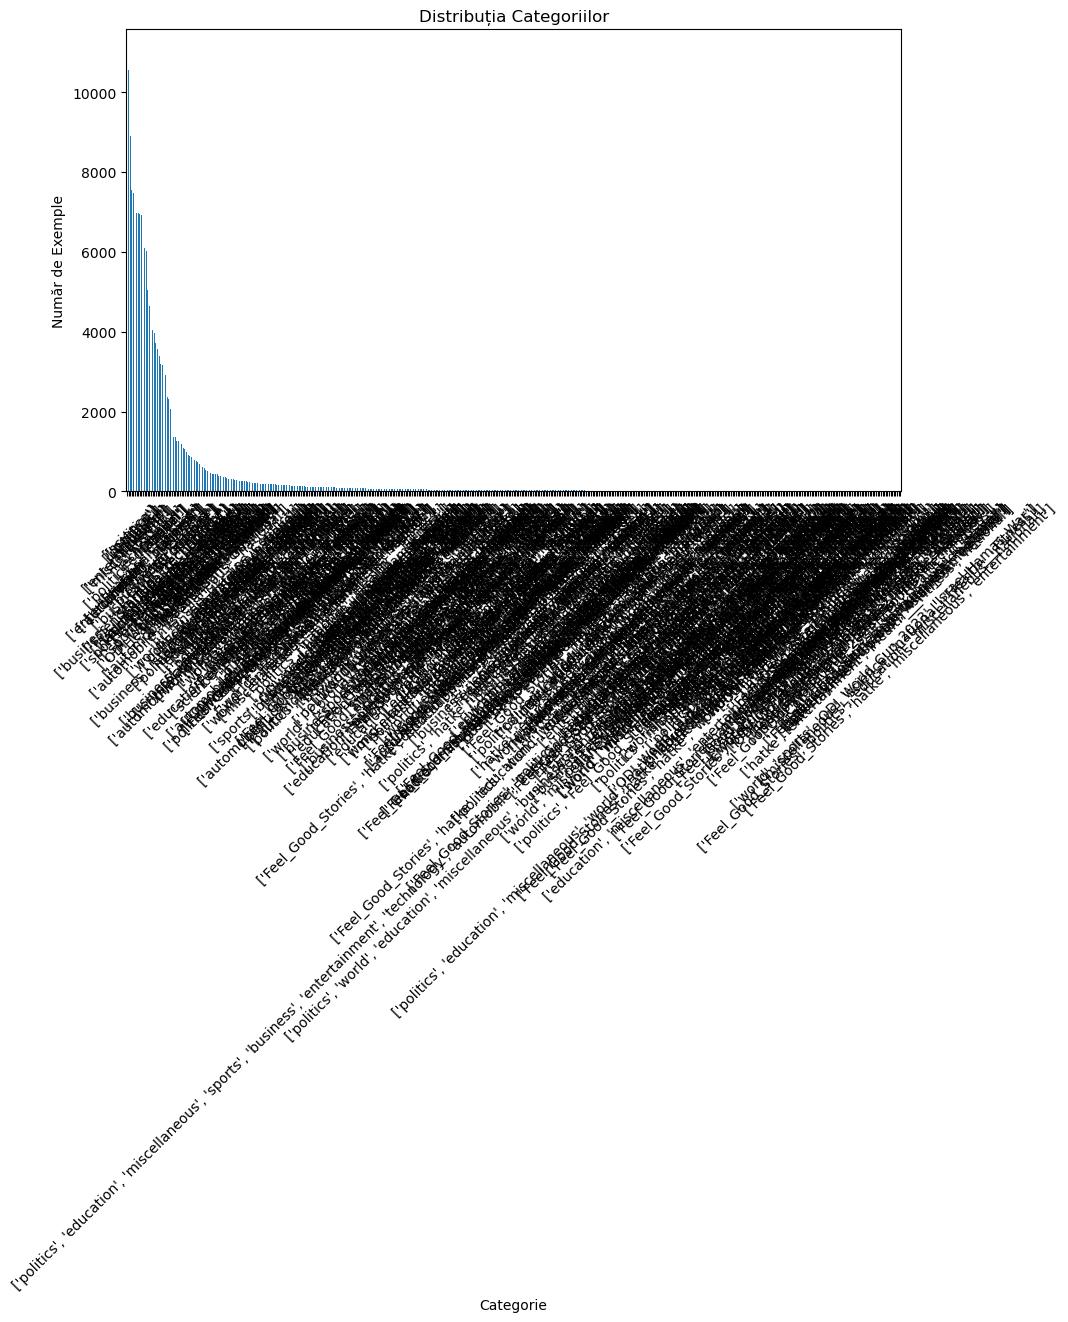

In [87]:
# Vizualizare distribuție
plt.figure(figsize=(10, 6))
df["category_grouped"].value_counts().plot(kind="bar")
plt.title("Distribuția Categoriilor")
plt.xlabel("Categorie")
plt.ylabel("Număr de Exemple")
plt.xticks(rotation=45)
plt.show()

In [1]:
top_n = 5
top_categories = df['News Categories'].value_counts().nlargest(top_n).index

df_top = df[df['News Categories'].isin(top_categories)]

sns.countplot(x='News Categories', data=df_top, palette='viridis')
plt.title(f'Top {top_n} News Categories')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show();

NameError: name 'df' is not defined

In [94]:
# Definim modelul T5 global pentru sumarizare
t5_model_name = "t5-small"
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name)
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)

In [95]:
# Funcție pentru sumarizare
def summarize_text(text):
    input_text = "summarize: " + text
    inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = t5_model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    return t5_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [96]:
# Funcție pentru clasificare
def predict(text):
    distilbert_model.eval()
    inputs = distilbert_tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = distilbert_model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return le.inverse_transform([predicted_class])[0]

In [97]:
# Funcție pentru a extrage textul dintr-un URL
def extract_text_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup.find_all("p")
        article_text = " ".join([para.get_text() for para in paragraphs])
        return article_text
    except Exception as e:
        print(f"Eroare la procesarea URL-ului: {e}")
        return ""

In [86]:
# Exemplu de utilizare cu URL
url = "https://www.aljazeera.com/news/liveblog/2025/1/20/donald-trump-inauguration-us-president-2025-live"

news_text = extract_text_from_url(url)
if news_text:
    summarized_text = summarize_text(news_text)
    print("Rezumatul articolului:\n", summarized_text)
    predicted_category = predict(summarized_text)
    print(f"Categoria prezisă pentru URL-ul dat: {predicted_category}")
else:
    print("Nu s-a putut extrage textul din URL.")

Eroare la procesarea URL-ului: 401 Client Error: HTTP Forbidden for url: https://www.reuters.com/world/us/trump-inauguration-live-us-prepares-new-president-be-sworn-2025-01-20/
Nu s-a putut extrage textul din URL.
